## The goal of this project is to predict the collision of nearest objects around the mighty **EARTH**



> Requirements
*   matplotlib                    3.5.1
*   numpy                        1.22.2
*   pandas                        1.4.1
*   scikit-learn                   1.1.1
*   scikit-plot                    0.3.7
*   seaborn                       0.11.2
*   tensorflow                    2.8.0
*   xgboost                       1.6.1
*   autoviz                       0.1.42
*   sklearn                       0.0






 
  
  
  
  
  
  
  
  




1. At first, switch the computational power to **GPU** from **CPU** using **CUDA**

In [60]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2. We will import warnings for removing the future warning in our terminal.

In [61]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

3. The official dataset is from NASA's official website https://cneos.jpl.nasa.gov/ca/ . And the modified version of this dataset is available on Kaggle. Link : https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects . After saving the CSV file we will read it using panda.

In [62]:
#reading the dataset using panda
import pandas as pd
data = pd.read_csv("/media/smn06/88849B27849B16B2/project/neo.csv")
print(data.shape)



(90836, 10)


4. Exploring the labels and types.

In [63]:
data.head()
print(data.dtypes)

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object



5. Checking is there any null value or not.


In [64]:
print(data.isnull().sum())


id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64


6. From the dataset, we can see that "Sentry_Object" and "Hazardous" labels data are in Boolean form. Where those are filled with 'True' and 'False'. We are going to encode them with 1 and 0

In [65]:
features = list(data.columns)
features = [a for a in features if a in ('sentry_object','hazardous')]
print(features)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for f in features:
    data[f]=le.fit_transform(data[f])
print(data.dtypes)

['sentry_object', 'hazardous']
id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object           int64
absolute_magnitude    float64
hazardous               int64
dtype: object


7. We can also see from the dataset that data from some of the labels are higher than the others, this can lead to a high covariance. So, we are going to use minmax scaler in the following columns - **'relative_velocity', 'miss_distance', 'absolute_magnitude'**. But first, we need to drop **'id','name','orbiting_body'**  because of irrelevency. 

In [66]:

data.drop(['id','name','orbiting_body'], axis = 1, inplace = True)
minmax = [ 'relative_velocity', 'miss_distance', 'absolute_magnitude']

#importing minmax scaling from sklearn and scaling to desired features
from sklearn.preprocessing import MinMaxScaler
scaled_data = data.copy()
features = scaled_data[minmax]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_data[minmax] = features
print(scaled_data.dtypes)

est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
sentry_object           int64
absolute_magnitude    float64
hazardous               int64
dtype: object


8. Now we are going to visualize the dataset using **Autoviz**. It can find the most important features and plot impactful visualizations for the dataset.

Shape of your Data Set loaded: (90836, 7)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    6 Predictors classified...
        1 variables removed since they were ID or low-information variables

################ Binary_Classification problem #####################


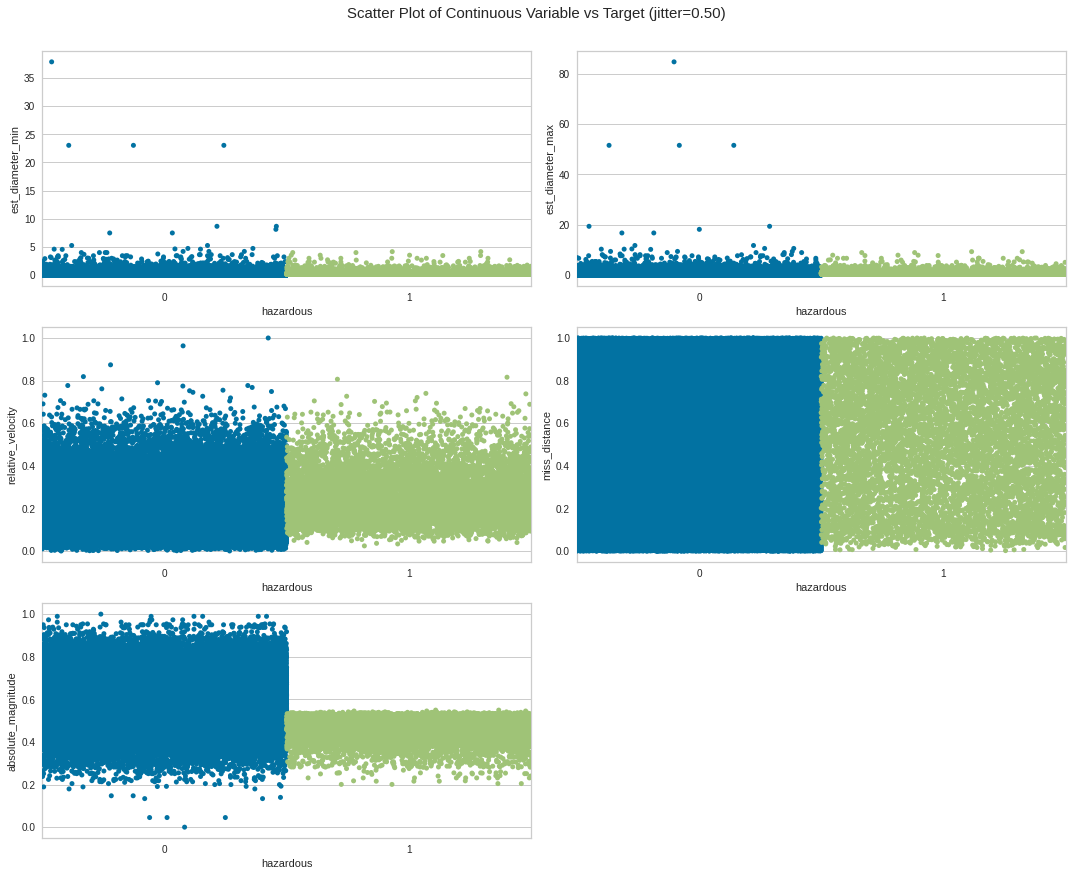

Total Number of Scatter Plots = 15


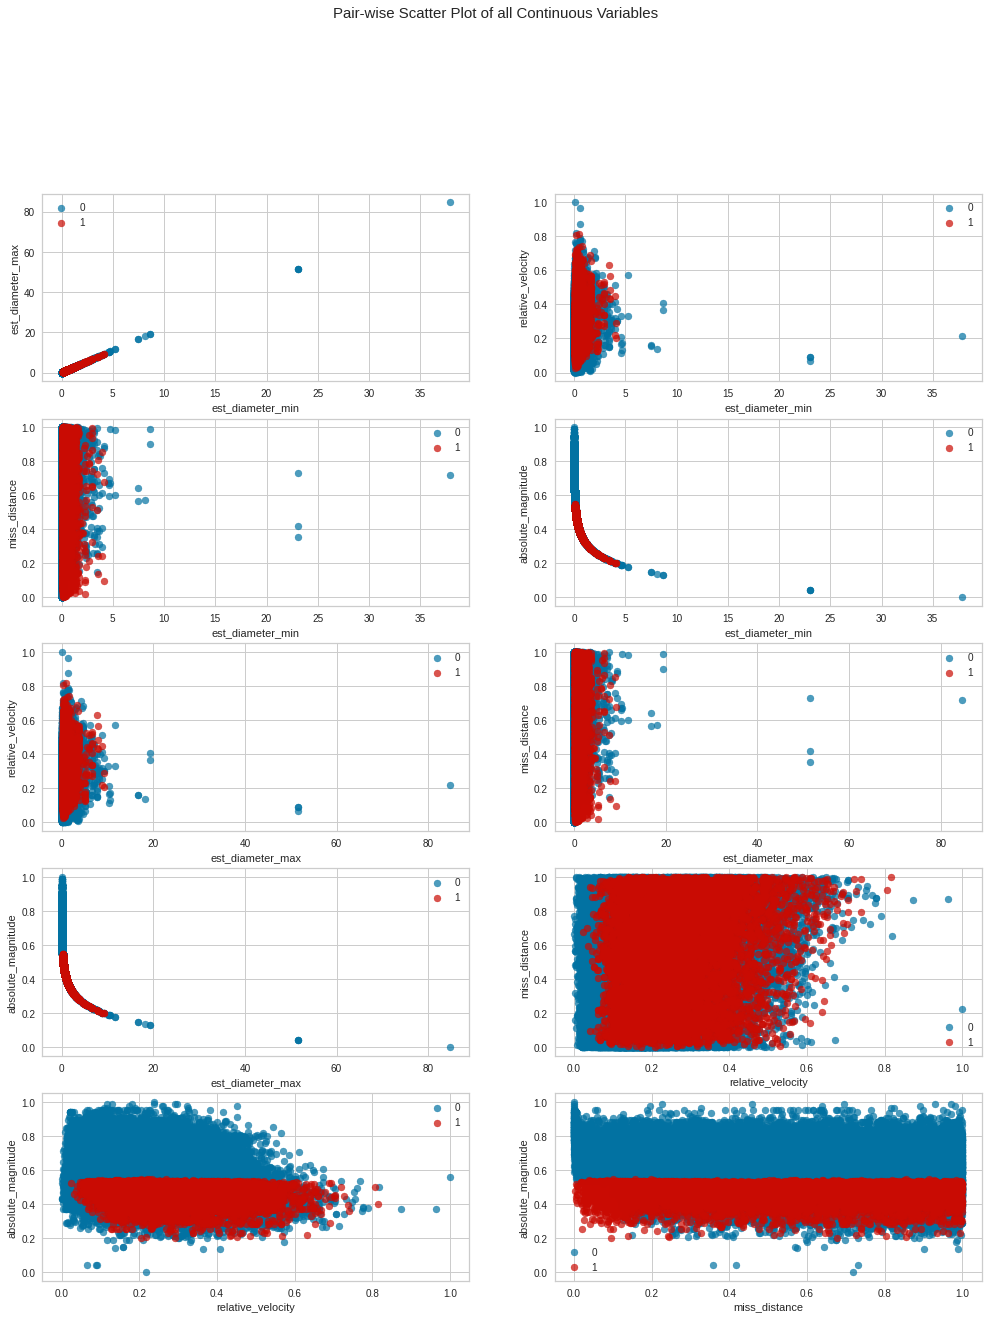

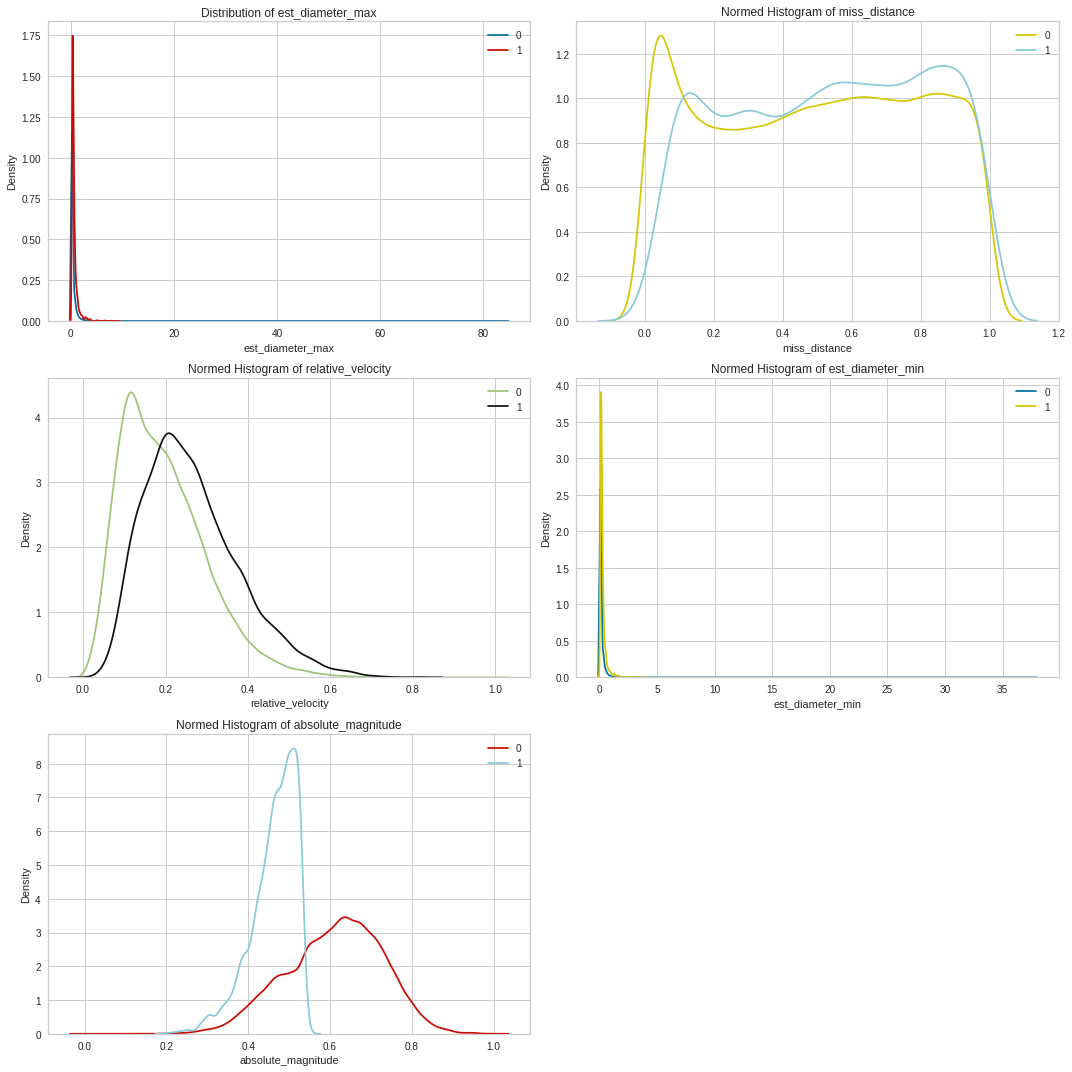

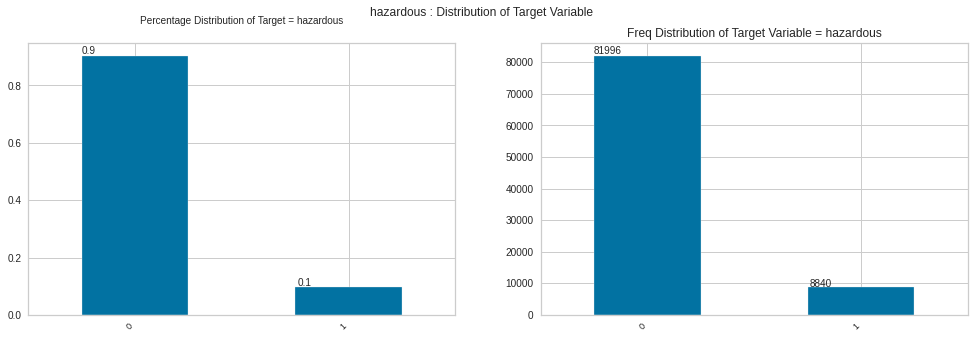

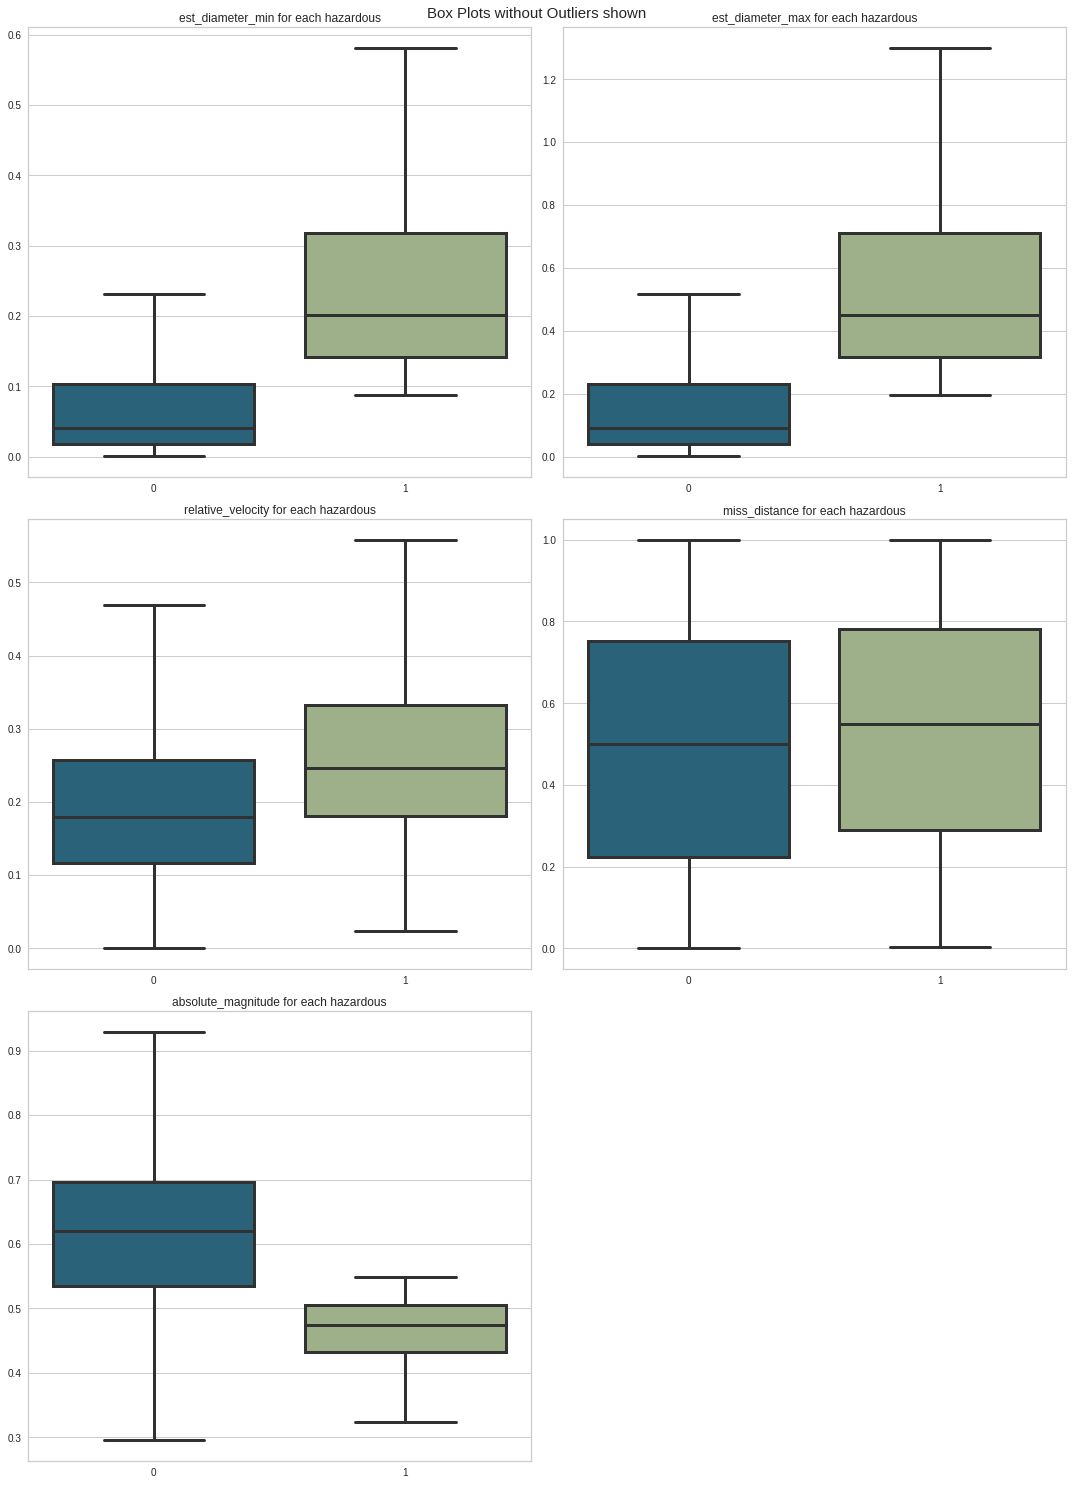

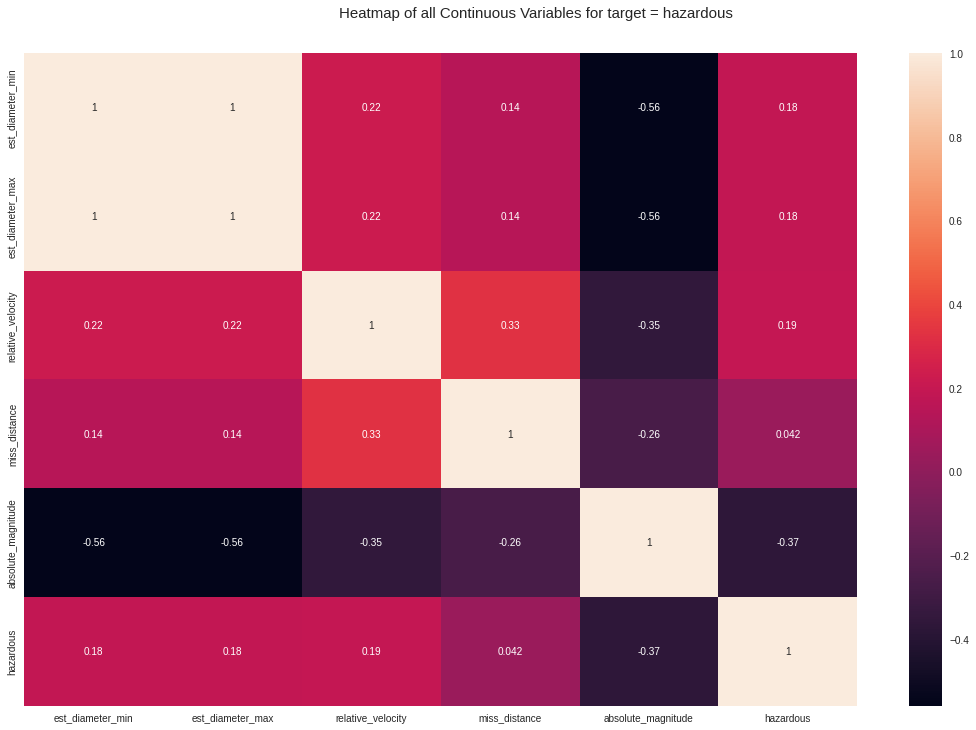

No categorical or boolean vars in data set. Hence no pivot plots...
No categorical or numeric vars in data set. Hence no bar charts.
Time to run AutoViz = 11 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [67]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
%matplotlib inline
target = 'hazardous'
dft = AV.AutoViz('', ',', target, scaled_data, max_rows_analyzed=99999,  max_cols_analyzed=30)

9. Now it's the time for getting the prediction result using classifier algorithms. But first, we need the train, test values and a visualizer function.

In [68]:
from sklearn.model_selection import train_test_split
X = scaled_data.drop(['hazardous'], axis = 1)
y = scaled_data.hazardous
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


> For the visualizer function, our target is to show confusion matrix, Precision, Recall, F-1 Score and Support for perfomance analysis.



In [69]:
"""function for visualize the result, first parameter is the model, second parameter is the 
confusion matrix, third parameter is the name of model and from the fourth to seventh are the values"""
def visualize(bayes, cm, strr, X_train, X_test, y_train, y_test):

  import seaborn as sns
  import numpy as np
  import matplotlib.pyplot as plt

  t = "Confusion Matrix for {}".format(strr)
  names = ['True Neg','False Pos','False Neg','True Pos']
  val_count = ["{0:0.0f}".format(value) for value in cm.flatten()]
  percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names,val_count,percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='OrRd')
  ax.set_title(t)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')

  # Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  # Display the visualization of the Confusion Matrix.
  plt.show()

  from sklearn.naive_bayes import GaussianNB
  from yellowbrick.classifier import ClassificationReport

  classes = ["False","True"]
  # Instantiate the classification model and visualizer
  visualizer = ClassificationReport(bayes, classes=classes, support=True)
  visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
  visualizer.score(X_test, y_test)  # Evaluate the model on the test data
  visualizer.show()




> 9.1     **Adaboost Classifier**
---



Adaboost Score =  0.9112686600026422


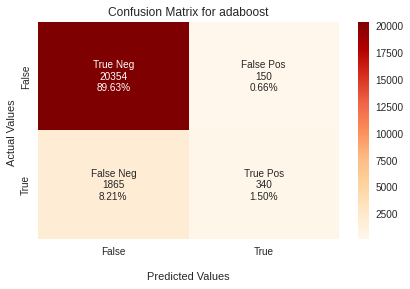

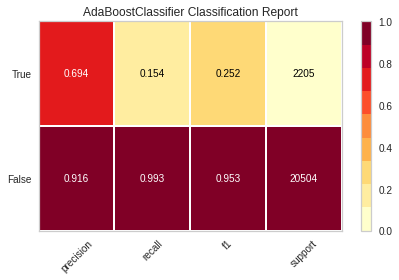

In [70]:
#importing and fitting the model from sklearn
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train,y_train)
score = ada.score(X_test, y_test)
print("Adaboost Score = ", score)

#importing confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = ada.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(ada,cm, "adaboost", X_train, X_test, y_train, y_test)

# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
ada_report = classification_report(y_test, y_test_pred, output_dict=True)
ada_macro_precision =  ada_report['macro avg']['precision']
ada_macro_recall = ada_report['macro avg']['recall']
ada_macro_f1 = ada_report['macro avg']['f1-score']
ada_accuracy = ada_report['accuracy']


> 9.2 **Logistic Regression**


---




Log Score =  0.9032101809855123


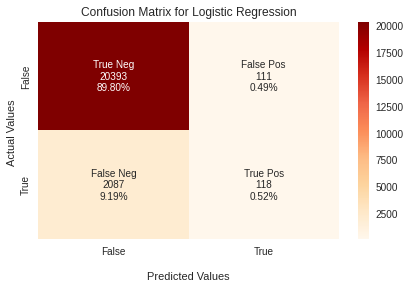

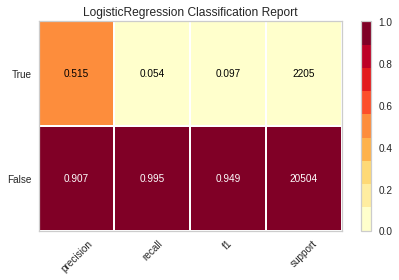

In [71]:
#importing and fitting the model from sklearn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='newton-cg', max_iter=1000)
logreg.fit(X_train,y_train)
score = logreg.score(X_test, y_test)
print("Log Score = ", score)

#importing confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(logreg, cm, "Logistic Regression", X_train, X_test, y_train, y_test)

# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
log_report = classification_report(y_test, y_test_pred, output_dict=True)
log_macro_precision =  log_report['macro avg']['precision']
log_macro_recall = log_report['macro avg']['recall']
log_macro_f1 = log_report['macro avg']['f1-score']
log_accuracy = log_report['accuracy']



> 9.3 **Multi-Layer Perceptron Classifier** 

---





MLP =  0.9121053326874807


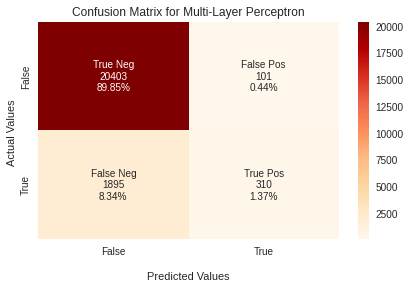

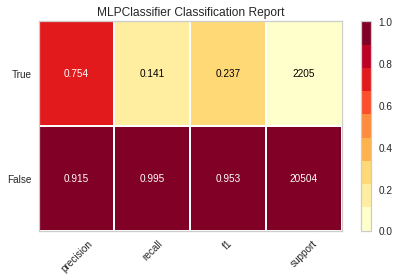

In [72]:
#importing and fitting the model from sklearn
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=45, max_iter=3000, learning_rate= 'adaptive' ).fit(X_train, y_train)
mlp_score = mlp.score(X_test, y_test)
print("MLP = ", mlp_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = mlp.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(mlp, cm, "Multi-Layer Perceptron", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
mlp_report = classification_report(y_test, y_test_pred, output_dict=True)
mlp_macro_precision = mlp_report['macro avg']['precision']
mlp_macro_recall = mlp_report['macro avg']['recall']
mlp_macro_f1 = mlp_report['macro avg']['f1-score']
mlp_accuracy = mlp_report['accuracy']


> 9.4 **Stochastic Gradient Descent (SGD) Classifier**


---




SGD = 0.90268175613193


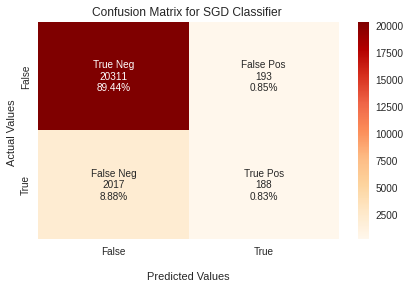

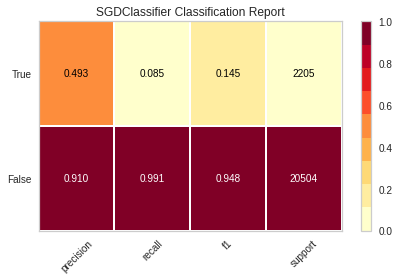

In [73]:
#importing and fitting the model from sklearn
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log_loss", eta0=1, learning_rate="adaptive", penalty=None)
sgd.fit(X_train,y_train)
sgd_score = sgd.score (X_test, y_test)
print("SGD =",sgd_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = sgd.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(sgd, cm, "SGD Classifier ", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
sgd_report = classification_report(y_test, y_test_pred, output_dict=True)
sgd_macro_precision =  sgd_report['macro avg']['precision']
sgd_macro_recall = sgd_report['macro avg']['recall']
sgd_macro_f1 = sgd_report['macro avg']['f1-score']
sgd_accuracy = sgd_report['accuracy']



> 9.5 **XGBoost Classifier**

---





XGBoost = 0.90268175613193


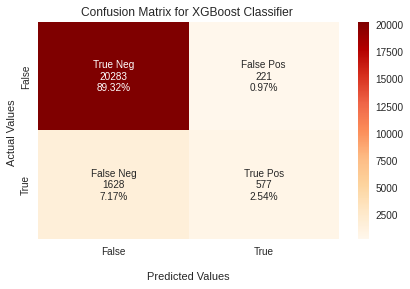

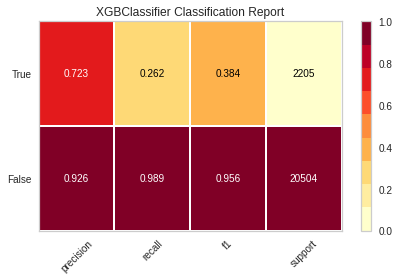

In [92]:
#importing and fitting the model from sklearn
import xgboost as xgb
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_train,y_train)
xgb_score = sgd.score (X_test, y_test)
print("XGBoost =",xgb_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(xgb, cm, "XGBoost Classifier ", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
xgb_report = classification_report(y_test, y_test_pred, output_dict=True)
xgb_macro_precision =  xgb_report['macro avg']['precision']
xgb_macro_recall = xgb_report['macro avg']['recall']
xgb_macro_f1 = xgb_report['macro avg']['f1-score']
xgb_accuracy = xgb_report['accuracy']



> 9.6 **Linear Perceptron Classifier**

---





Perceptron =  0.822008895151702


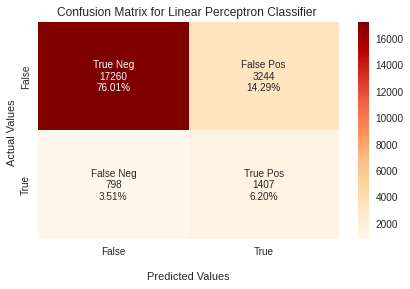

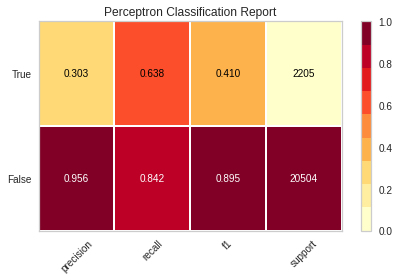

In [75]:
#importing and fitting the model from sklearn
from sklearn.linear_model import Perceptron
per = Perceptron(alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=10000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, random_state=0)
per.fit(X_train,y_train)
per_score = per.score(X_test, y_test)
print("Perceptron = ",per_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = per.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(per, cm, "Linear Perceptron Classifier ", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
per_report = classification_report(y_test, y_test_pred, output_dict=True)
per_macro_precision =  per_report['macro avg']['precision']
per_macro_recall = per_report['macro avg']['recall']
per_macro_f1 = per_report['macro avg']['f1-score']
per_accuracy = per_report['accuracy']



> 9.7 **Support Vector Classification**

---





svc =  0.8903958782861421


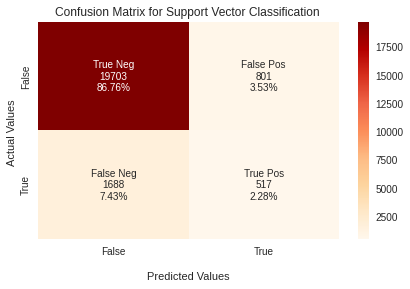

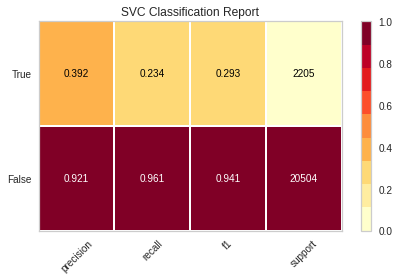

In [76]:
#importing and fitting the model from sklearn
from sklearn.svm import SVC
svc = SVC(kernel = 'sigmoid', C = 0.025, random_state=100, probability=True)
svc.fit(X_train,y_train)
svc_score = svc.score (X_test, y_test)
print("svc = ", svc_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(svc, cm, "Support Vector Classification ", X_train, X_test, y_train, y_test)

# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
svc_report = classification_report(y_test, y_test_pred, output_dict=True)
svc_macro_precision =  svc_report['macro avg']['precision']
svc_macro_recall = svc_report['macro avg']['recall']
svc_macro_f1 = svc_report['macro avg']['f1-score']
svc_accuracy = svc_report['accuracy']



> 9.8   **Gradient Boosting Classifier**

---





grad_score =  0.902901933154256


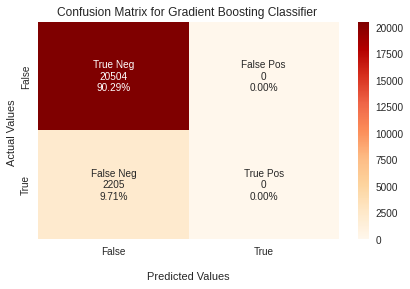

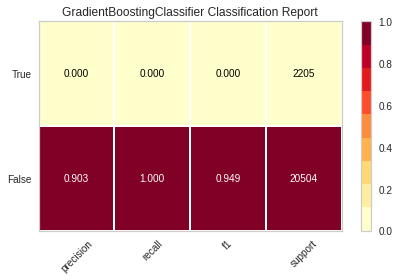

In [77]:
#importing and fitting the model from sklearn
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(loss='log_loss', n_estimators=150, learning_rate=0.0005, max_depth=1, random_state=45).fit(X_train, y_train)
grad_score = grad.score(X_test, y_test)
print("grad_score = ",grad_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = grad.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(grad, cm, "Gradient Boosting Classifier ", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
gbc_report = classification_report(y_test, y_test_pred, output_dict=True)
gbc_macro_precision =  gbc_report['macro avg']['precision']
gbc_macro_recall = gbc_report['macro avg']['recall']
gbc_macro_f1 = gbc_report['macro avg']['f1-score']
gbc_accuracy = gbc_report['accuracy']




> 9.9 **K - Nearest Neighbors Classifier**

---





KNN_score =  0.9027698269408605


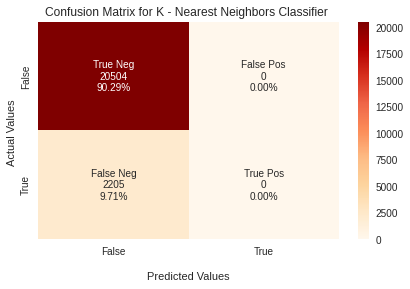

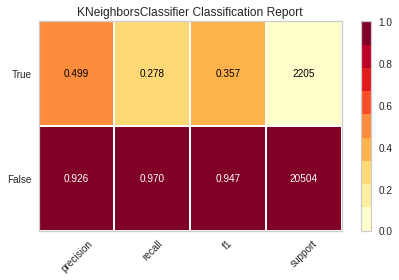

In [78]:
#importing and fitting the model from sklearn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors= 7, algorithm= 'kd_tree')
knn.fit(X_train,y_train)
knn_score = knn.score(X_test, y_test)
print("KNN_score = ",knn_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(knn, cm, "K - Nearest Neighbors Classifier ", X_train, X_test, y_train, y_test)


# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
knn_report = classification_report(y_test, y_test_pred, output_dict=True)
knn_macro_precision =  knn_report['macro avg']['precision']
knn_macro_recall = knn_report['macro avg']['recall']
knn_macro_f1 = knn_report['macro avg']['f1-score']
knn_accuracy = knn_report['accuracy']



> 9.10 **Random Forest Classifier**

---





RFM_score =  0.9159364128759523


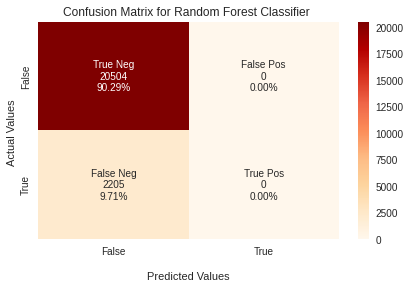

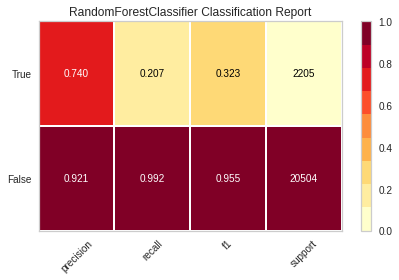

In [79]:
#importing and fitting the model from sklearn
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier(criterion='log_loss', n_estimators= 100, oob_score= True, n_jobs = 1, random_state=100, max_features= 'sqrt', min_samples_leaf= 20)                    
rfm.fit(X_train,y_train)
rfm_score = rfm.score(X_test, y_test)
print("RFM_score = ",rfm_score)

#importing the confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
y_test_pred = rfm.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
visualize(rfm, cm, "Random Forest Classifier ", X_train, X_test, y_train, y_test)

# saving the classification report values for comparison at last
from sklearn.metrics import classification_report
rfc_report = classification_report(y_test, y_test_pred, output_dict=True)
rfc_macro_precision =  rfc_report['macro avg']['precision']
rfc_macro_recall = rfc_report['macro avg']['recall']
rfc_macro_f1 = rfc_report['macro avg']['f1-score']
rfc_accuracy = rfc_report['accuracy']

### It's time for comparison between the results. 


> we will use panda's dataframe to hold all the results.



In [93]:
#creating a table of storing the results using panda's dataframe and rounding the values into three digits
table = pd.DataFrame({
    'Model': ['Adaboost', 'Logistic Regression','Multi Layer Perceptron', 'Stochastic Gradient Descent', 'XGBoost',
              'Linear Perceptron', 'Support Vector', 'Gradient Boosting', 'K-Nearest Neighbor', 'Random Forest'],
    'Accuracy': [round(ada_accuracy, 3), round(log_accuracy, 3), round(mlp_accuracy, 3), round(sgd_accuracy, 3), round(xgb_accuracy, 3),
                 round(per_accuracy, 3), round(svc_accuracy, 3), round(gbc_accuracy, 3), round(knn_accuracy, 3), round(rfc_accuracy, 3)],
    
    'Macro Precision': [round(ada_macro_precision, 3), round(log_macro_precision, 3), round(mlp_macro_precision, 3), round(sgd_macro_precision, 3), round(xgb_macro_precision, 3), 
                        round(per_macro_precision, 3), round(svc_macro_precision, 3), round(gbc_macro_precision, 3), round(knn_macro_precision, 3), round(rfc_macro_precision, 3)],
    
    'Macro Recall': [round(ada_macro_recall, 3), round(log_macro_recall, 3), round(mlp_macro_recall, 3), round(sgd_macro_recall, 3), round(xgb_macro_recall, 3), 
                        round(per_macro_recall, 3), round(svc_macro_recall, 3), round(gbc_macro_recall, 3), round(knn_macro_recall, 3), round(rfc_macro_recall, 3)],
    
    'Macro F1': [round(ada_macro_f1, 3), round(log_macro_f1, 3), round(mlp_macro_f1, 3), round(sgd_macro_f1, 3), round(xgb_macro_f1, 3), 
                        round(per_macro_f1, 3), round(svc_macro_f1, 3), round(gbc_macro_f1, 3), round(knn_macro_f1, 3), round(rfc_macro_precision, 3)]})
# total_table.sort_values(by='AUC', ascending=False)
print(table)

                         Model  Accuracy  Macro Precision  Macro Recall  \
0                     Adaboost     0.911            0.805         0.573   
1          Logistic Regression     0.903            0.711         0.524   
2       Multi Layer Perceptron     0.912            0.835         0.568   
3  Stochastic Gradient Descent     0.903            0.702         0.538   
4                      XGBoost     0.919            0.824         0.625   
5            Linear Perceptron     0.822            0.629         0.740   
6               Support Vector     0.890            0.657         0.598   
7            Gradient Boosting     0.903            0.451         0.500   
8           K-Nearest Neighbor     0.903            0.451         0.500   
9                Random Forest     0.903            0.451         0.500   

   Macro F1  
0     0.603  
1     0.523  
2     0.595  
3     0.547  
4     0.670  
5     0.653  
6     0.617  
7     0.474  
8     0.474  
9     0.451  
